In [1]:
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import numpy as np
import dianna
import onnx

from metrics import Incremental_deletion

from onnx_tf.backend import prepare
import matplotlib.pyplot as plt
from pathlib import Path

2023-06-07 11:18:38.547937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 11:18:38.630937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 11:18:38.632376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 11:18:39.701937: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# # load dataset
data = np.load(Path().absolute().parent / 'data/binary-mnist.npz')
# load testing data and the related labels
X_test = data['X_test'].astype(np.float32).reshape([-1, 28, 28, 1]) / 255

In [3]:
# Load saved onnx model
onnx_model_path = Path('../models', 'mnist_model_tf.onnx')
onnx_model = onnx.load(onnx_model_path)
# get the output node
output_node = prepare(onnx_model, gen_tensor_dict=True).outputs[0]

The predicted class is: digit 0


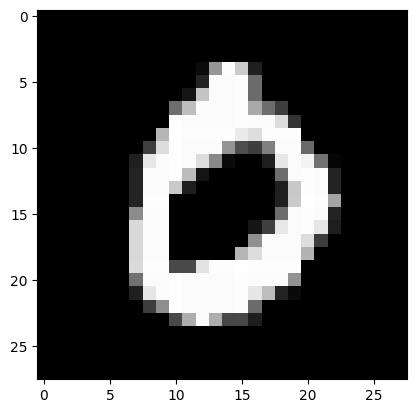

In [4]:
# class name
class_name = ['digit 0', 'digit 1']
# instance index
i_instance = 1
# select instance for testing
test_sample = X_test[i_instance].copy().astype(np.float32)
# model predictions with added batch axis to test sample
predictions = prepare(onnx_model).run(test_sample[None, ...])[f'{output_node}']
pred_class = class_name[np.argmax(predictions)]
print("The predicted class is:", pred_class)
plt.imshow(X_test[i_instance][:,:,0], cmap='gray')  # 0 for channel

In [5]:
# use KernelSHAP to explain the network's predictions
shap_values, segments_slic = dianna.explain_image(onnx_model_path, test_sample, labels=[1],
                                                  method="KernelSHAP", nsamples=1000,
                                                  background=0, n_segments=200, sigma=0,
                                                  axis_labels=('height','width','channels'))

100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


In [6]:
# fill each pixel with SHAP values 
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

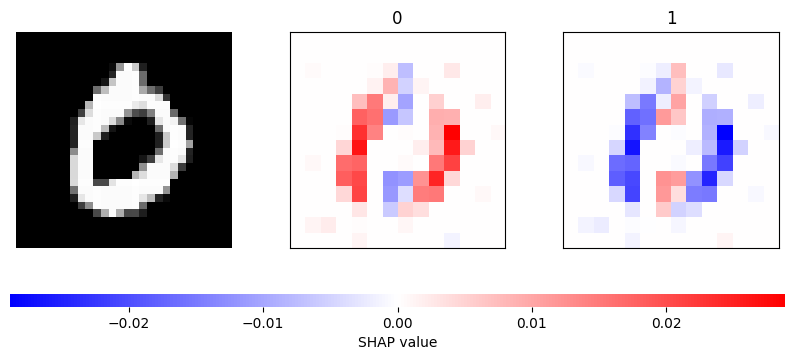

In [7]:
# get the index of predictions
top_preds = np.argsort(-predictions)
inds = top_preds[0]
# Visualize the explanations
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
axes[0].imshow(test_sample, cmap='gray')
axes[0].axis('off')
# get the range for color bar
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
# plot the test image and the attributions on the image for each class
for i in range(2):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(str(inds[i]))
    axes[i+1].imshow(test_sample, alpha=0.15)
    im = axes[i+1].imshow(m, vmin=-max_val, vmax=max_val, cmap='bwr')
    #axes[i+1].axis('off')
    axes[i+1].set_xticks([])
    axes[i+1].set_yticks([])
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

In [8]:
deleter = Incremental_deletion(model = onnx_model_path, step=1)

from dianna import visualization

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


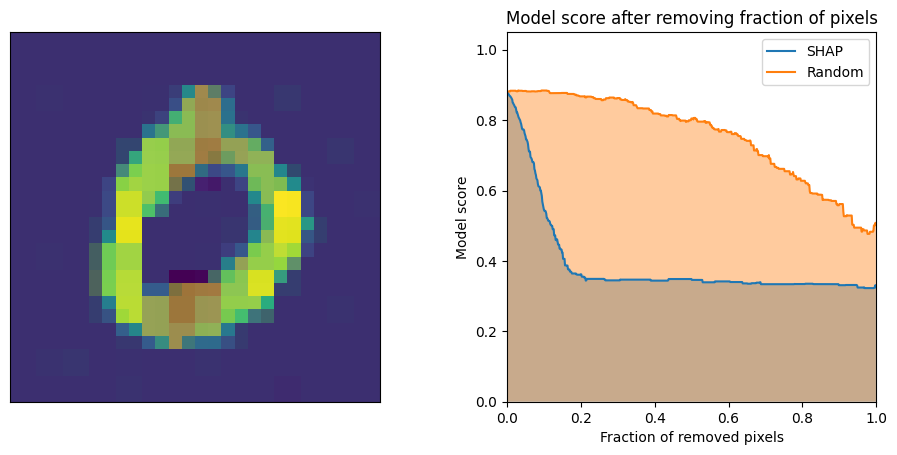

[array([0.88126731, 0.88226235, 0.87883019, 0.87544835, 0.87261093,
        0.87079567, 0.86817473, 0.8677274 , 0.86575121, 0.86364055,
        0.86068994, 0.85807252, 0.84932405, 0.84822923, 0.84440935,
        0.84273618, 0.8387481 , 0.83672595, 0.83628196, 0.82949138,
        0.82189119, 0.82185811, 0.817213  , 0.81211388, 0.80755502,
        0.80518532, 0.80194068, 0.79965121, 0.79369098, 0.78956348,
        0.78306156, 0.7754057 , 0.77342439, 0.77342439, 0.77342439,
        0.77130294, 0.7628873 , 0.75878614, 0.75405073, 0.74517918,
        0.74525011, 0.74190247, 0.73824805, 0.73130637, 0.71869612,
        0.71064878, 0.71064878, 0.71064878, 0.69543749, 0.69316417,
        0.6911611 , 0.68693101, 0.68076408, 0.68074208, 0.68045205,
        0.67719638, 0.66076267, 0.65721869, 0.64890283, 0.64412367,
        0.63415331, 0.63156688, 0.62940007, 0.61853307, 0.6124869 ,
        0.61125439, 0.61058027, 0.60882449, 0.59980673, 0.59985965,
        0.59288412, 0.58455145, 0.5682525 , 0.56

In [12]:
salience_map = fill_segmentation(shap_values[0][0], segments_slic)

results = deleter(test_sample.astype(np.float32), salience_map[None, ...], batch_size=784, n_samples=1, impute_method='full_mode')

sal = results['salient_scores'] 

# sal[sal < 0.5] = 0.5

scores = (np.mean(results['salient_scores'], axis=0), 
          np.mean(results['random_scores'], axis=0))

_  = deleter.visualize(salience_map, test_sample, scores, ('SHAP', 'Random'))

results['salient_scores']